In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from feature_engine.datetime import DatetimeFeatures
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score 
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

import pickle
import joblib

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
sklearn.set_config(transform_output='default')

### Reading the dataset

In [4]:
train_df = pd.read_csv('dataset/train.csv')
valid_df = pd.read_csv('dataset/val.csv')
test_df = pd.read_csv('dataset/test.csv')

In [5]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


In [6]:
test_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-03,Delhi,Cochin,18:15:00,01:35:00,440,1.0,No Info,18916
1,Jet Airways,2019-06-01,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,10262
2,Multiple Carriers,2019-06-06,Delhi,Cochin,07:05:00,16:10:00,545,1.0,No Info,9646
3,Air India,2019-03-24,Kolkata,Banglore,16:50:00,18:30:00,1540,1.0,No Info,14641
4,Multiple Carriers,2019-05-27,Delhi,Cochin,10:20:00,19:00:00,520,1.0,No Info,9794
...,...,...,...,...,...,...,...,...,...,...
195,Spicejet,2019-04-21,Kolkata,Banglore,06:55:00,09:30:00,155,0.0,No Info,4174
196,Multiple Carriers,2019-06-01,Delhi,Cochin,11:40:00,19:15:00,455,1.0,No Info,10261
197,Indigo,2019-03-21,Mumbai,Hyderabad,21:20:00,22:45:00,85,0.0,No Info,2227
198,Jet Airways,2019-06-03,Delhi,Cochin,16:00:00,12:35:00,1235,1.0,In-flight meal not included,10262


In [7]:
valid_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-01,Delhi,Cochin,05:15:00,19:15:00,2280,3.0,No Info,10703
1,Air India,2019-03-03,Delhi,Cochin,20:00:00,19:15:00,1395,2.0,No Info,17266
2,Air India,2019-03-06,Mumbai,Hyderabad,05:55:00,22:00:00,965,1.0,No Info,10366
3,Goair,2019-06-09,Kolkata,Banglore,16:40:00,00:15:00,455,1.0,No Info,9495
4,Jet Airways,2019-06-03,Delhi,Cochin,20:55:00,19:00:00,1325,1.0,No Info,14714
...,...,...,...,...,...,...,...,...,...,...
155,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included,4098
156,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info,12475
157,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info,10197
158,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info,26890


## Checking for null values and separating columns according to dtype

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          200 non-null    object 
 1   date_of_journey  200 non-null    object 
 2   source           200 non-null    object 
 3   destination      200 non-null    object 
 4   dep_time         200 non-null    object 
 5   arrival_time     200 non-null    object 
 6   duration         200 non-null    int64  
 7   total_stops      200 non-null    float64
 8   additional_info  200 non-null    object 
 9   price            200 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 15.8+ KB


In [10]:
target = ['price']
num_columns = ['duration', 'total_stops']
dt_columns = ['date_of_journey', 'dep_time', 'arrival_time']
cat_columns = [column for column in train_df.columns if (column not in num_columns) and (column not in dt_columns) and (column not in target)]

In [11]:
cat_columns

['airline', 'source', 'destination', 'additional_info']

In [12]:
num_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scale', StandardScaler())                      
])

cat_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) 
])

date_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('date', DatetimeFeatures(features_to_extract=['month', 'year', 'day_of_week', 'day_of_month'],format='mixed')),
    ('scale', StandardScaler())     
])

time_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('time', DatetimeFeatures(features_to_extract=['hour', 'minute', 'second'])),
    ('scale', StandardScaler())
])

In [13]:
preprocessor = ColumnTransformer([
    ('numerical', num_transformer, num_columns),
    ('category', cat_transformer, cat_columns),
    ('date', date_transformer, ['date_of_journey'] ),
    ('time', time_transformer, ['dep_time', 'arrival_time'])
])

In [14]:
preprocessor.fit_transform(train_df)

F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


array([[-1.09591823, -1.21213152,  0.        , ..., -0.34523131,
         1.49385907,  0.        ],
       [ 1.43569944,  0.31797533,  0.        , ..., -0.93560684,
         0.89104078,  0.        ],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.34523131,
        -1.21882323,  0.        ],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.78801296,
         1.49385907,  0.        ],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.1307075 ,
        -1.52023237,  0.        ],
       [ 0.63833955,  0.31797533,  0.        , ..., -0.19763743,
        -1.52023237,  0.        ]])

In [15]:
algorithms = {
    'linear_regression': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'svm' : SVR(),
    'xgboost' : XGBRegressor()
}

In [16]:
algorithms

{'linear_regression': LinearRegression(),
 'random_forest': RandomForestRegressor(),
 'svm': SVR(),
 'xgboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}

In [17]:
data = pd.concat([train_df, valid_df], axis=0)
data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
155,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included,4098
156,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info,12475
157,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info,10197
158,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info,26890


In [18]:
def split_data(data):
    x = data.drop(columns='price')
    y = data.price.copy()
    return (x, y)

In [19]:
x_data, y_data = split_data(data)

In [20]:
x_data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
155,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included
156,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info
157,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info
158,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info


In [21]:
y_data

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
155     4098
156    12475
157    10197
158    26890
159     4990
Name: price, Length: 800, dtype: int64

In [22]:
def plot_curve(sizes, mean_score, std_score, label, ax):
    ax.plot(sizes, mean_score, marker='o', label = label)

    ax.fill_between(x=sizes,
		y1=mean_score - std_score,
		y2=mean_score + std_score,
		alpha=0.5
                   )

In [23]:
def plot_learning_curve(name, algorithm):
    model = Pipeline(steps=[
        ('processor', preprocessor),
        ('alg', algorithm)
    ])

    size, train_scores, test_scores = learning_curve(
        estimator=model,
        X=x_data,
        y=y_data,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=(10, 5))

    # training curve
    plot_curve(
        size,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    # test curve
    plot_curve(
        size,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")
    plt.show()


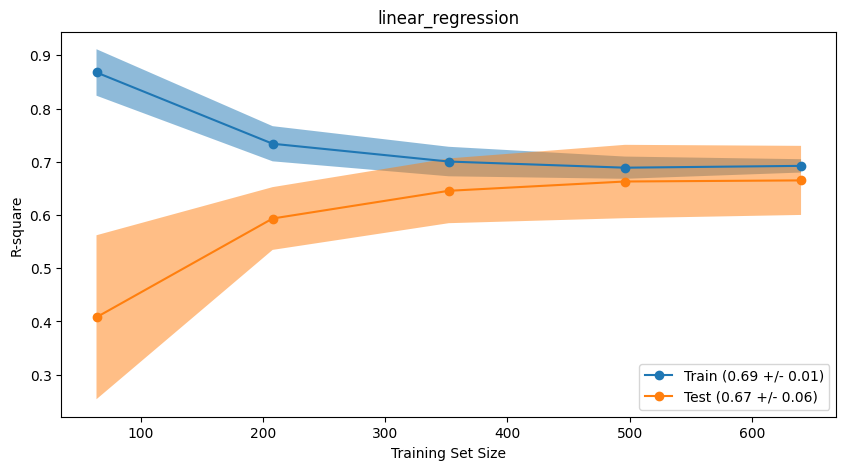

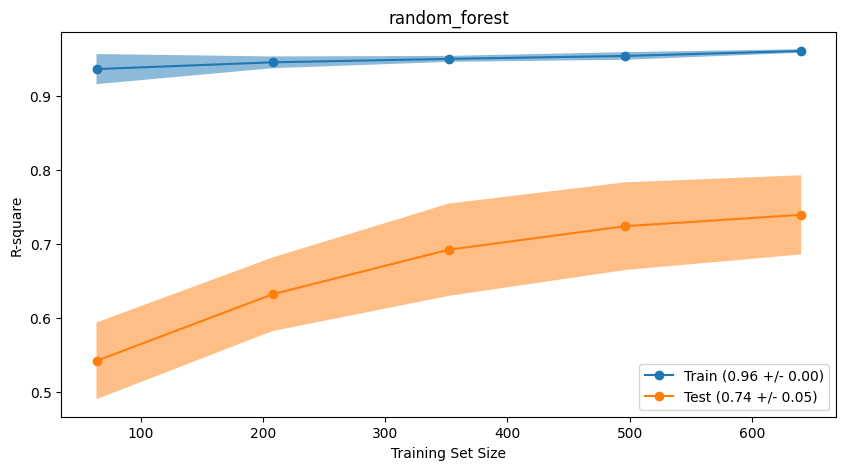

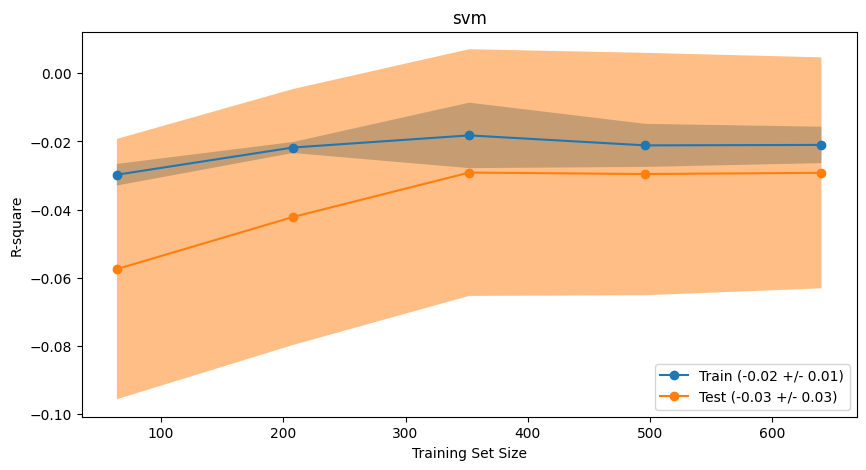

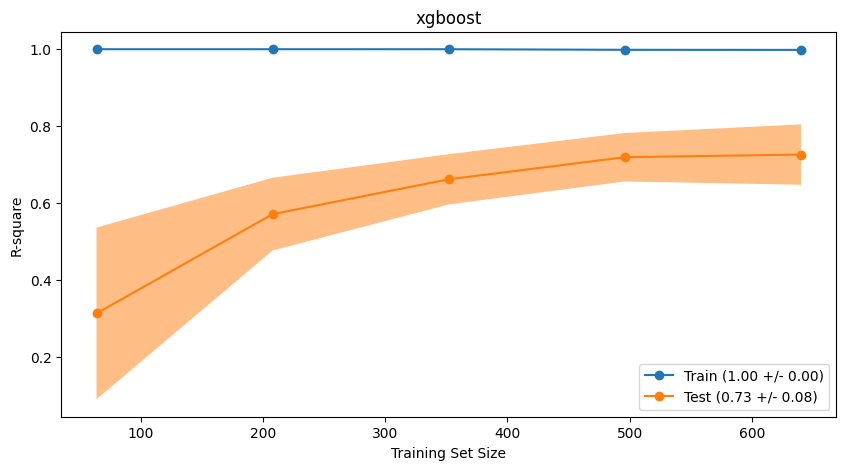

In [24]:
for name, alg in algorithms.items():
	plot_learning_curve(name, alg)

In [58]:
model = Pipeline(steps=[
        ('processor', preprocessor),
        ('alg', RandomForestRegressor())
    ])

In [59]:
model.fit(x_data, y_data)

F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airlin...
                                                                   DatetimeFeatures(features_to_extract=['month',
                                                                                                         'year',
                                                                                                         'day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('time',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute',
                                                                                                         'second'])),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('alg', RandomForestRegressor())])

### Performing prediction on test dataset

In [63]:
x_test, y_test = split_data(test_df)

In [64]:
pred = model.predict(x_test)

F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


In [65]:
evaluate_model(pred, y_test)

0.6439388809054751

### Sa

In [69]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [72]:
with open ('model.pkl', 'rb') as f:
    load_model = pickle.load(f)

In [76]:
prediction = load_model.predict(x_test)
evaluate_model(prediction, y_test)

F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
F:\Data Science\Deployment_using_flask\model_deploymentment\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


0.6439388809054751

### Understanding the working of Learning Curve

In [30]:
model = Pipeline(steps=[
        ('processor', preprocessor),
        ('alg', LinearRegression())
    ])

size, train_scores, test_scores = learning_curve(
        estimator=model,
        X=x_data,
        y=y_data,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

In [31]:
size

array([ 64, 208, 352, 496, 640])

In [32]:
train_scores

array([[0.78050329, 0.88970623, 0.88970623, 0.88970623, 0.88970623],
       [0.69317501, 0.79448662, 0.72729523, 0.72729523, 0.72729523],
       [0.64569246, 0.71396902, 0.70625479, 0.71820275, 0.71820275],
       [0.66086783, 0.71978905, 0.70516984, 0.67902164, 0.67972475],
       [0.67252599, 0.70559792, 0.70616256, 0.68842758, 0.68894955]])

In [34]:
test_scores

array([[0.11801841, 0.5342107 , 0.41281758, 0.43179985, 0.54249924],
       [0.65487622, 0.57277012, 0.4949604 , 0.59198871, 0.65246009],
       [0.72596142, 0.57011045, 0.5788078 , 0.67302799, 0.67954343],
       [0.75325555, 0.56075844, 0.60871123, 0.69920294, 0.69282248],
       [0.75953405, 0.57340459, 0.61411143, 0.68964988, 0.68844599]])

In [39]:
np.mean(train_scores, axis=1)

array([0.86786564, 0.73390947, 0.70046435, 0.68891462, 0.69233272])